In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
import pymc
import seaborn
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.fftpack import fft, rfft, fftshift
import pickle
import time as datetime
import pandas
import pprint

import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_fit_v05 as pf
import pulse_fit_v06 as pf6
import single_photon_model_no_shift as noshift
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import thres
import stats_proc as sp

import pulse_utils as pu
import discriminator as disc
import discriminator_edges as disc_edges
import trace_param as trcp

In [2]:
# Imports CW traces
directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.array(filelist)
# filelist = np.flipud(np.sort(filelist))
filelist = np.sort(filelist)
print(filelist[0:2])
print len(filelist)

[ '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']
400000


In [3]:
t_initial = None
t_final = None
height_th = 0.00773176320829
noise_th = 0.00183298303024

/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles16335.trc


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


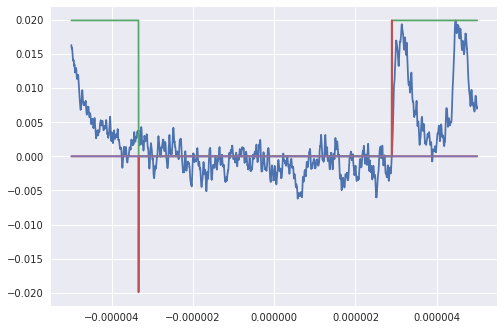

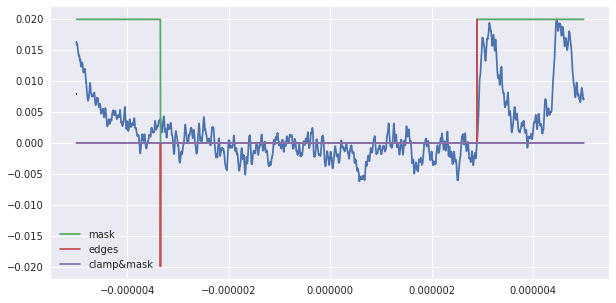

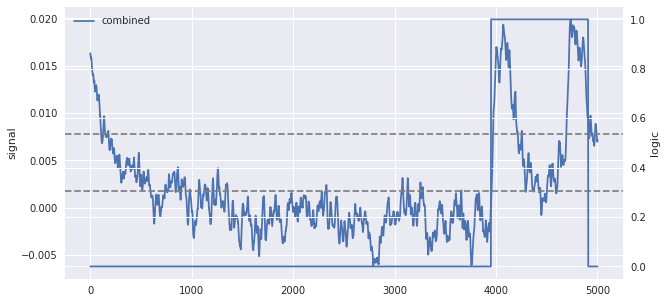

In [14]:
reload(pu)
reload(disc)
reload(disc_edges)
reload(hpa)
# interesting_traces=np.genfromtxt(results_directory + 'edge_disc_failure_traces.dat',
#                                  delimiter='\n',
#                                  dtype='string')

# t, s = hpa.trace_extr(np.setdiff1d(filelist,interesting_traces)[15]
#                       ,height_th)
fname = interesting_traces[13]
print fname
t,_ = hpa.trace_extr(fname, height_th)
s = trcp.trace_extr(fname,height_th)
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(t,s[1:], 
                                                                  dt_left=0,dt_right=1300e-9, 
                                                                  height_th=height_th, 
                                                                  Plot=True, 
                                                                  method=2)
plt.show()
%matplotlib inline
plt.figure()
f, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax.plot(s)
ax.axhline(height_th, linestyle = '--', color = 'grey', label='height_th')
ax.axhline(noise_th, linestyle = '--', color = 'grey', label='noise_th')
# ax2.legend()

mask = pu.disc_peak_full(s,height_th,0,650)

# mask_f = disc_edges.disc_edges(s,height_th,noise_th)
# mask_b  = np.flipud(disc_edges.disc_edges(np.flipud(s),height_th,0))
# mask = pu.disc_edges_full(s,height_th,noise_th)

ax2.plot(mask,label='combined')

ax.set_ylabel('signal')
ax2.set_ylabel('logic')
ax2.legend()

In [62]:
reload(pd)
%timeit pd.discriminator(t,s[1:], dt_left=0,dt_right=1300e-9, height_th=height_th, Plot=False, method=2)

10 loops, best of 3: 162 ms per loop


In [44]:
reload(pu)
%timeit pu.disc_peak_full(s,height_th,0,650)

1000 loops, best of 3: 386 µs per loop


In [5]:
# np.savetxt('peak_disc_challenging_twoandahalf_traces.txt',
#            np.take(interesting_traces, [5,7,17,18,25,28]))
append2file('peak_disc_challenging_forward_neq_backward_traces.txt',
            interesting_traces[70])

NameError: name 'append2file' is not defined

In [6]:
def append2file(filename,text):
    with open(filename,"a+") as f:
        f.write(text+'\n')
        f.close()

In [295]:
reload(hpa)
reload(pu)
reload(disc)
tasks = tqdm.tqdm(filelist[:10000])
data_cont_=np.array([hpa.param_extr(f,height_th,noise_th/1000) for f in tasks])
# for f in tasks:
#     try:
#         _,s = hpa.trace_extr(f,height_th)
#         pu.disc_edges_full(s, height_th, noise_th)
#     except:
#         append2file('edge_disc_failure_traces.dat',f)

100%|██████████| 10000/10000 [00:31<00:00, 322.02it/s]


(0, 500)

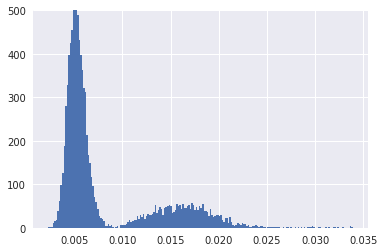

In [229]:
plt.figure()
plt.hist(data_cont_['height'],200);
plt.ylim(0,500)

In [220]:
import thres_poiss as thres_poiss

In [68]:
pnr_height_clamped = np.histogram(data_cont_0th_abs_extend_simple[:,1], 150)
th = thres_poiss.thresholds_N(pnr_height_clamped, min_peak_sep=0.01, weighted=True)
print th[0]

0.00782961701626


In [5]:
height_th=0.00782961701626
# height_th=0.00803902717278

In [6]:
mask_0ph = data_cont_0th_abs_extend_simple[:,1] < height_th

In [7]:
noise_th = np.mean(data_cont_0th_abs_extend_simple[:,2][mask_0ph] )
# noise_th = 0.0017635801619151478

In [8]:
reload(pu)
reload(disc)
reload(disc_edges)
reload(hpa)
tasks = tqdm.tqdm(filelist[:400000])
data_cont_0th_abs_extend_simple_ = np.array([hpa.param_extr(f,height_th,0,650) for f in tasks])

100%|██████████| 400000/400000 [22:44<00:00, 293.05it/s]


In [42]:
np.savetxt(results_directory+'data_cont_0th_abs_extend_simple.dat',data_cont_0th_abs_extend_simple)

In [11]:
data_cont_0th_abs_extend_simple = np.loadtxt(results_directory+'data_cont_0th_abs_extend_simple.dat')

(0, 6000)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


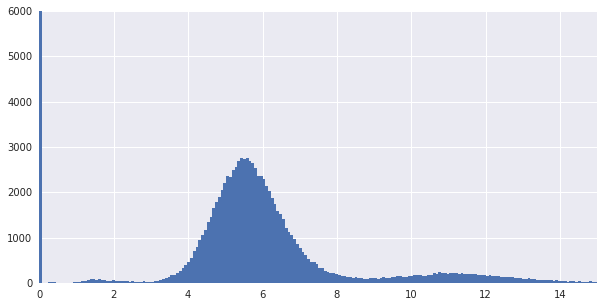

In [8]:
plt.figure(figsize=(10,5))
plt.hist(data_cont_0th_abs_extend_simple[:,0],200,range=[0,15]);
# plt.hist(data_cont_0th_abs_extend_simple['area_win'],200);
plt.xlim(0,15)
plt.ylim(0,6000)

In [12]:
# area = data_cont_0th_abs_extend_simple['area_win']
area = data_cont_0th_abs_extend_simple[:,0]

In [13]:
interesting_traces = filelist[:][(area>8.6) & (area<9)]

In [11]:
pnr_height_from_cw = np.histogram(area, 200)

est peak pos = [  1.69632713   5.51306318  11.16748695  14.41878062]
 est peak hts = [ 140 5193  427   60]
2.75653158938


/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode/thres.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 3
  peak_height = peak_height[peaks_pos>th01]


[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_'))
[[Variables]]
    n_bar:          0.26062527 (init= 0.2)
    A:              55255.2993 (init= 15579)
    Delta_E:        68.0007558 (init= 3.251294)
    sigma_p:        0.91477378 (init= 0.6752372)
    g1_center:      5.63261754 (init= 5.513063)
    g2_center:      11.0542035 (init= 11.16749)
    g3_center:      16.1754214 (init= 14.41878)
    g1_amplitude:   11096.9171  == 'A * exp(-n_bar) * n_bar**1 / factorial(1)'
    g2_amplitude:   1446.06851  == 'A * exp(-n_bar) * n_bar**2 / factorial(2)'
    g3_amplitude:   125.627332  == 'A * exp(-n_bar) * n_bar**3 / factorial(3)'
    g1_sigma:       0.91477378  == 'sigma_p * sqrt(1)'
    g2_sigma:       1.29368548  == 'sigma_p * sqrt(2)'
    g3_sigma:       1.58443466  == 'sigma_p * sqrt(3)'



(0, 1750)

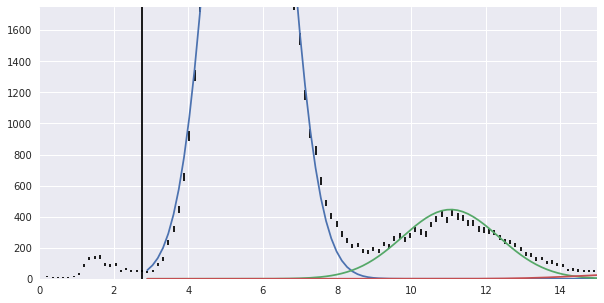

In [12]:
reload(thres)
%matplotlib inline
result = thres.gauss_fit_poiss_ph_region(pnr_height_from_cw,
                                          min_peak_sep=3, 
                                          threshold=1e-2, 
                                          weighted=True,
                                               plot=True)

# np.savetxt(results_directory+'area_mus.dat',area_mus)
# np.savetxt(results_directory+'area_sigmas.dat',area_sigmas)
plt.xlim(0,15)
plt.ylim(0,1750)
# print np.sort(area_mus), area_sigmas[np.argsort(area_mus)]

In [13]:
reload(thres)
result = thres.thresholds_N(pnr_height_from_cw,
                          min_peak_sep=3, 
                          threshold=1e-2, 
                          weighted=True)

est peak pos = [  1.69632713   5.51306318  11.16748695  14.41878062]
 est peak hts = [ 140 5193  427   60]
2.75653158938
at threshold 7.95537909585 between 5.63261754895 and 11.054203496:
prob signal lost = 0.00830234323691
prob noise enters = 0.00555587060419
at threshold 13.4379535861 between 11.054203496 and 16.1754214315:
prob signal lost = 0.0420187435957
prob noise enters = 0.0326934228203


In [66]:
heights = data_cont_0th_abs_extend_simple[:,1]

(0, 0.02)

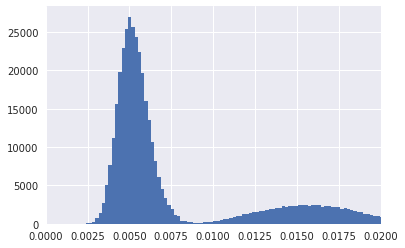

In [69]:
plt.hist(heights,200);
plt.xlim(0,0.02)